In [225]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [226]:
color_pal = sns.color_palette()
plt.style.use('seaborn-darkgrid')

In [227]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [228]:
df= pd.read_csv("datasets/PJME_hourly.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [272]:
df.Datetime=pd.to_datetime(df.Datetime)
df=df.set_index("Datetime")
df

AttributeError: 'DataFrame' object has no attribute 'Datetime'

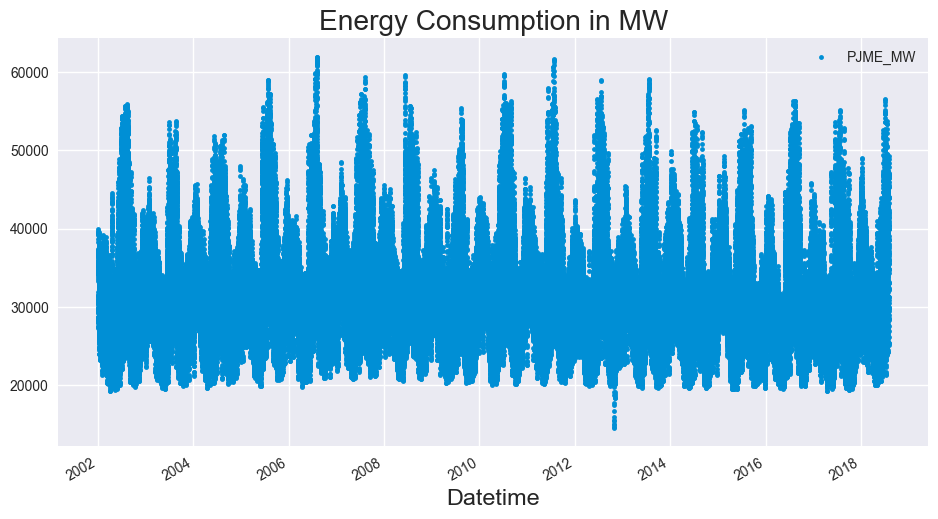

In [230]:
df.plot(style=".",
        color=color_pal[0],
        title="Energy Consumption in MW",
        figsize=(10,6));

## Train/Test split

In [231]:
train_df = df.loc[df.index < "01-01-2015"]
test_df  = df.loc[df.index >= "01-01-2015"]

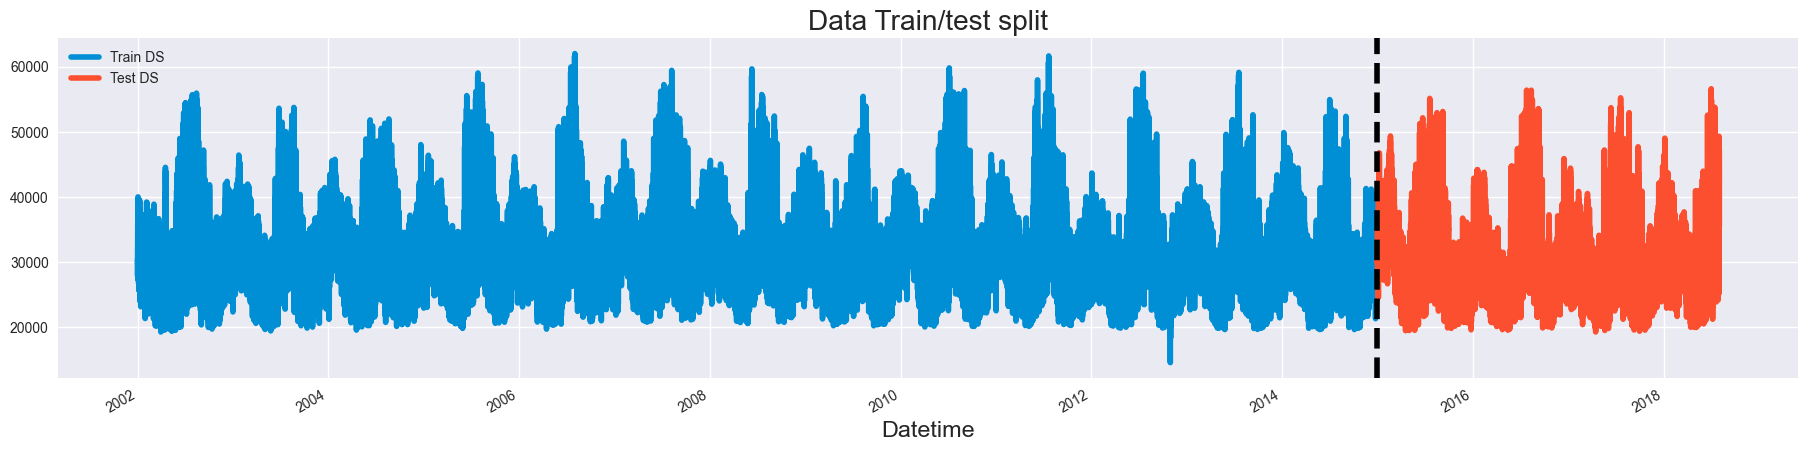

In [232]:
fig,ax = plt.subplots(figsize=(20,5))
train_df.plot(ax=ax,title="Data Train/test split")
test_df.plot(ax=ax)
ax.axvline("01-01-2015",ls="dashed",color="black")
ax.legend(["Train DS","Test DS"]);

### plot 1 week

<AxesSubplot:title={'center':'1 Week'}, xlabel='Datetime'>

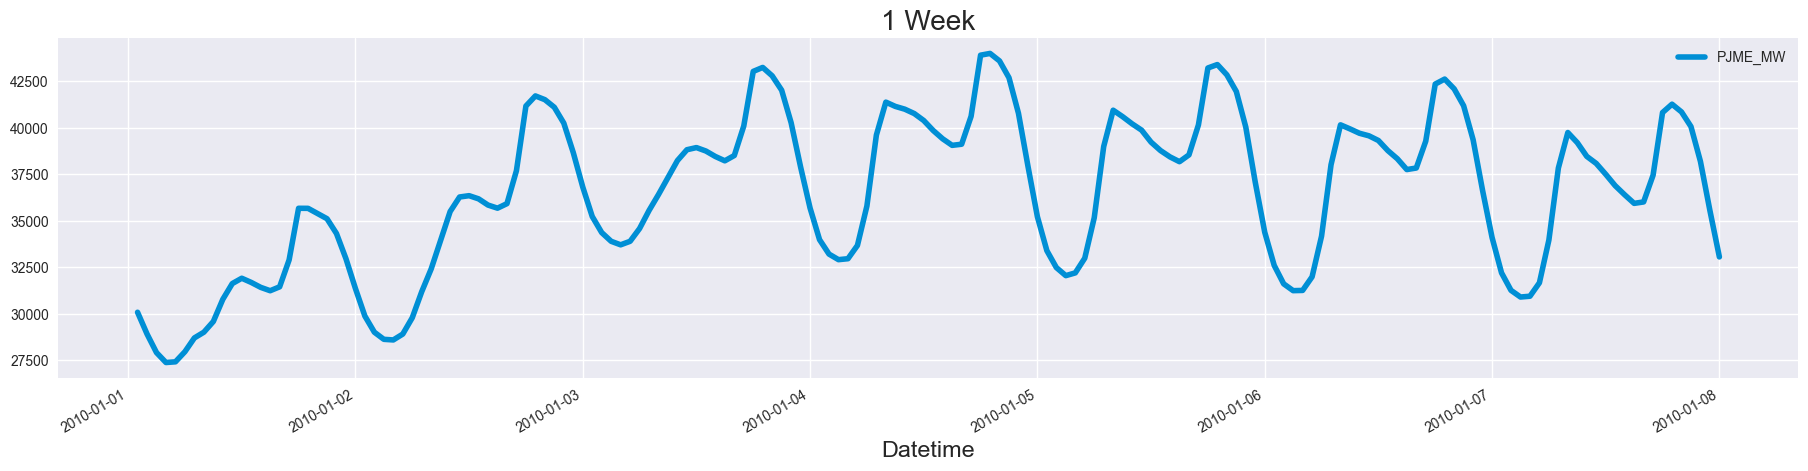

In [233]:
df.loc[(df.index > "01-01-2010")&(df.index <= "01-08-2010")]\
    .plot(figsize=(20,5),title="1 Week")

## create features

In [234]:
pd.set_option("max_colwidth",130)

In [235]:
def create_features(df):
    df_ex =df.copy()
    df_ex["hour"] = df.index.hour
    df_ex["dayofweek"]=df.index.weekday
    df_ex['weekofyear'] = df.index.isocalendar().week
    df_ex["month"]= df.index.month
    df_ex["quarter"]= df.index.quarter
    df_ex["year"]= df.index.year
    df_ex["dayofyear"]=df.index.day_of_year
    
    return df_ex

In [236]:
df = create_features(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   PJME_MW     145366 non-null  float64
 1   hour        145366 non-null  int64  
 2   dayofweek   145366 non-null  int64  
 3   weekofyear  145366 non-null  UInt32 
 4   month       145366 non-null  int64  
 5   quarter     145366 non-null  int64  
 6   year        145366 non-null  int64  
 7   dayofyear   145366 non-null  int64  
dtypes: UInt32(1), float64(1), int64(6)
memory usage: 9.6 MB


In [237]:
df.query("hour == 0").query("PJME_MW == PJME_MW.min()")

,PJME_MW,hour,dayofweek,weekofyear,month,quarter,year,dayofyear
Datetime,,,,,,,,
2012-10-30,15919.0,0,1,44,10,4,2012,304


In [238]:
df.query("hour == 1").query("PJME_MW == PJME_MW.min()")

,PJME_MW,hour,dayofweek,weekofyear,month,quarter,year,dayofyear
Datetime,,,,,,,,
2012-10-30 01:00:00,15390.0,1,1,44,10,4,2012,304


In [239]:
df.query("hour == 23").query("PJME_MW == PJME_MW.min()")

,PJME_MW,hour,dayofweek,weekofyear,month,quarter,year,dayofyear
Datetime,,,,,,,,
2012-10-29 23:00:00,17422.0,23,0,44,10,4,2012,303


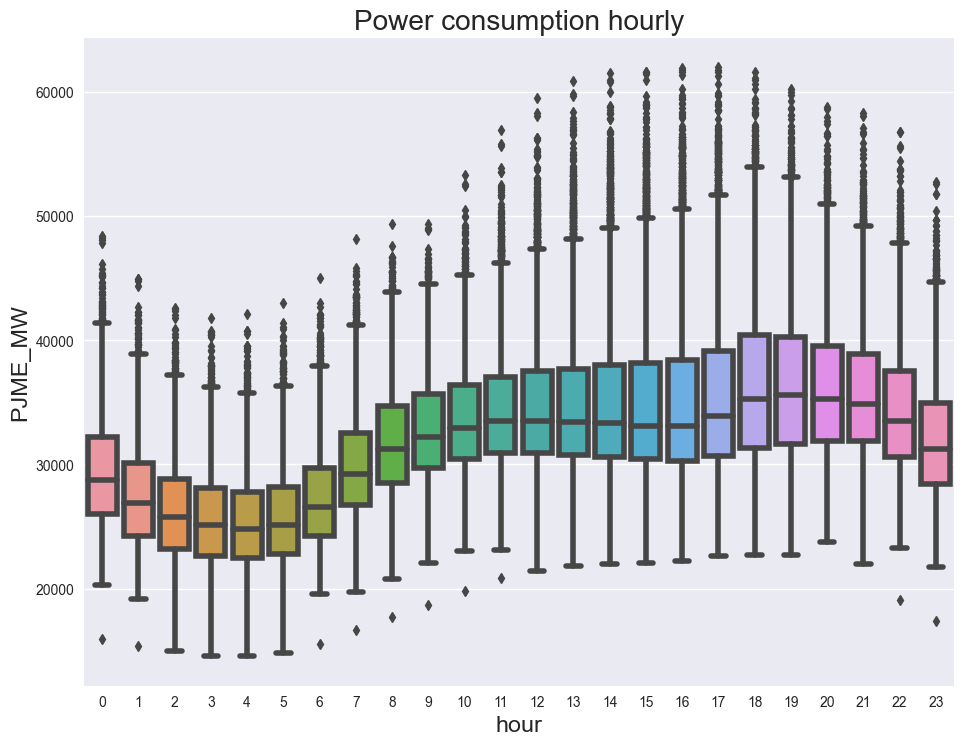

In [240]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(df,x="hour",y="PJME_MW")
plt.title("Power consumption hourly");

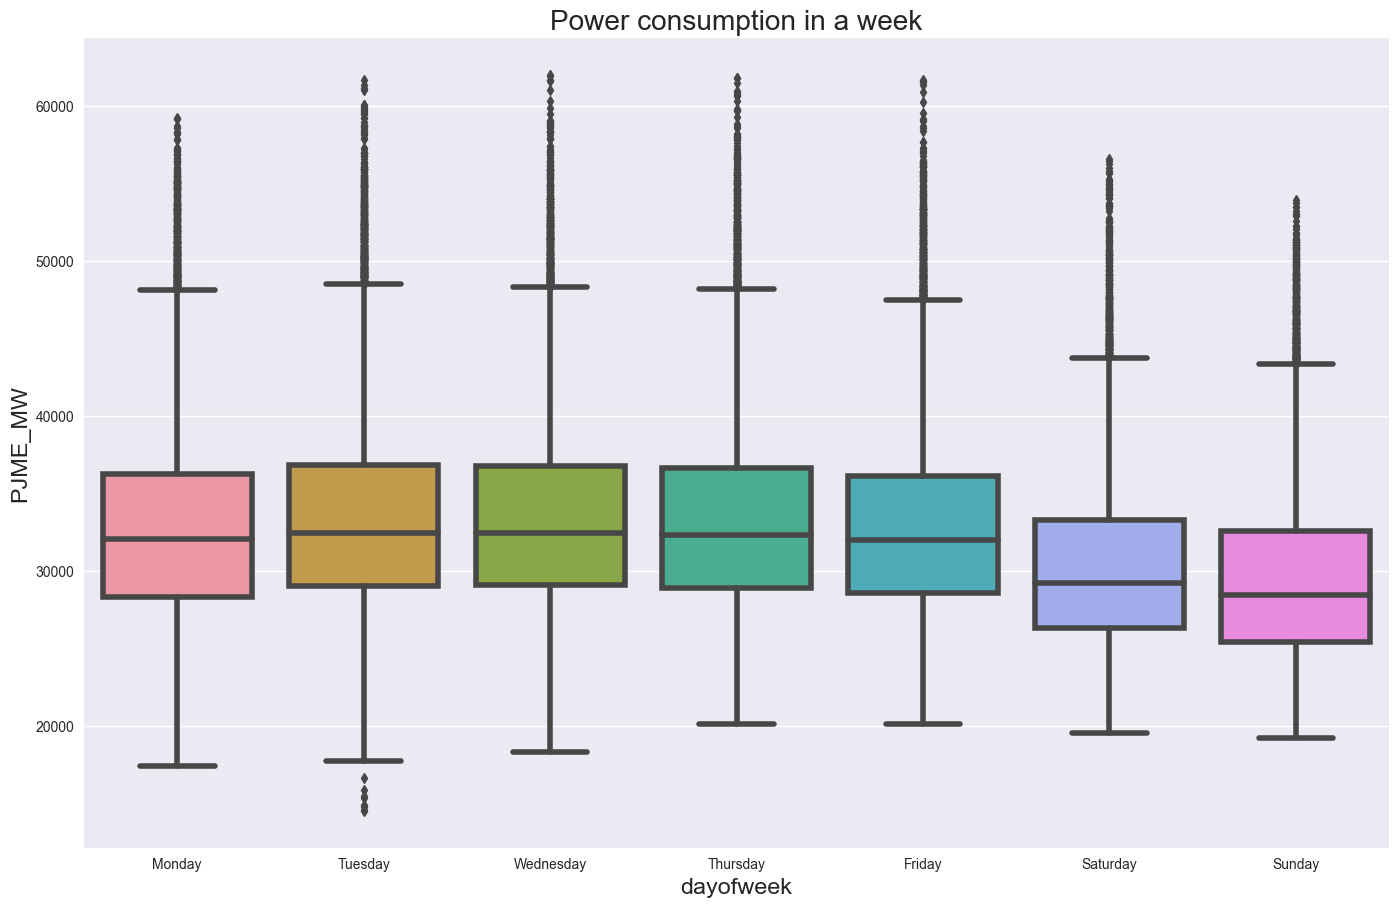

In [241]:
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(df,x="dayofweek",y="PJME_MW")
plt.title("Power consumption in a week")
plt.xticks(ticks=[0,1,2,3,4,5,6],labels=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]);

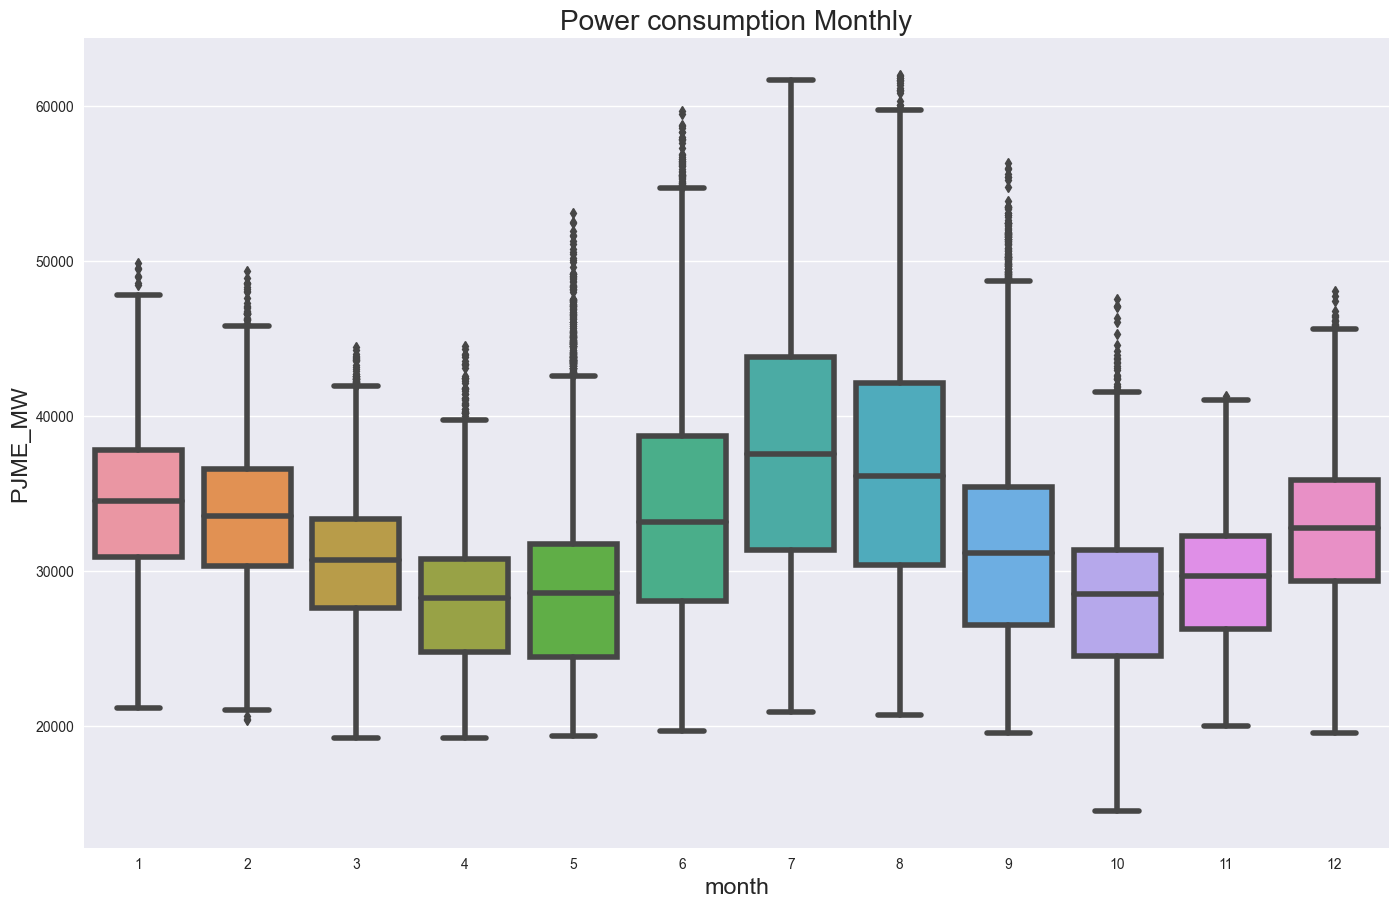

In [242]:
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(df,x="month",y="PJME_MW")
plt.title("Power consumption Monthly");

## Setup a Model

In [243]:
train_df = create_features(train_df)
test_df  = create_features(test_df)
FEATURES =["hour","dayofweek","month","quarter","year","dayofyear"]
TARGET = "PJME_MW"

# unlike non Time-Series Data , Split between Train and test can not de reandom, 
# but it have to be continous piece of data to keep timing features consistent
X_train = train_df[FEATURES]
y_train = train_df[TARGET]

X_test = test_df[FEATURES]
y_test = test_df[TARGET]

In [244]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 113926 entries, 2002-12-31 01:00:00 to 2014-01-02 00:00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   hour       113926 non-null  int64
 1   dayofweek  113926 non-null  int64
 2   month      113926 non-null  int64
 3   quarter    113926 non-null  int64
 4   year       113926 non-null  int64
 5   dayofyear  113926 non-null  int64
dtypes: int64(6)
memory usage: 6.1 MB


In [245]:
xgb_reg = xgb.XGBRegressor(booster="gbtree",
                       base_score = 0.5,
                       n_estimators = 1000,
                       early_stopping_rounds = 50,
                       max_depth = 3,
                       learning_rate = 0.02,
                       objective="reg:squarederror")
xgb_reg.fit(X_train,y_train,
            eval_set =[(X_train,y_train),(X_test,y_test)],
            verbose=50)

[0]	validation_0-rmse:32283.18267	validation_1-rmse:31335.13516
[50]	validation_0-rmse:12414.11041	validation_1-rmse:11581.43729
[100]	validation_0-rmse:5766.69973	validation_1-rmse:5306.80959
[150]	validation_0-rmse:3898.80776	validation_1-rmse:4012.01651
[200]	validation_0-rmse:3438.58992	validation_1-rmse:3857.39872
[250]	validation_0-rmse:3284.16941	validation_1-rmse:3809.39559
[300]	validation_0-rmse:3203.05568	validation_1-rmse:3770.82924
[350]	validation_0-rmse:3149.17927	validation_1-rmse:3752.55814
[400]	validation_0-rmse:3109.87066	validation_1-rmse:3735.76063
[450]	validation_0-rmse:3080.21824	validation_1-rmse:3724.76567
[500]	validation_0-rmse:3050.95640	validation_1-rmse:3722.71450
[550]	validation_0-rmse:3025.05304	validation_1-rmse:3725.29628
[561]	validation_0-rmse:3019.29915	validation_1-rmse:3725.37117


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

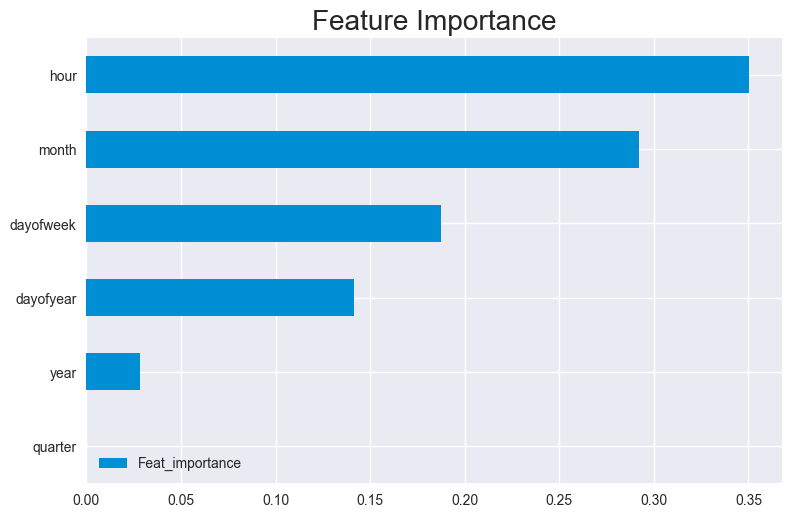

In [246]:
Feat_imp=pd.DataFrame(data = xgb_reg.feature_importances_,
             index= xgb_reg.feature_names_in_,
             columns=["Feat_importance"])
Feat_imp.sort_values("Feat_importance").plot(kind="barh")
plt.title("Feature Importance");
# Note. when features are correlated, feature_importance would give an OKIE insights but might not be the best way
#ex: 

## Forecast

In [247]:
test_df["predict"] = xgb_reg.predict(X_test)

In [248]:
df.shape

(145366, 8)

In [249]:
df = df.merge(test_df.predict, how='left',left_index=True,right_index=True)

In [250]:
df.shape

(145372, 9)

Text(0.5, 1.0, 'Raw Data and Prediction')

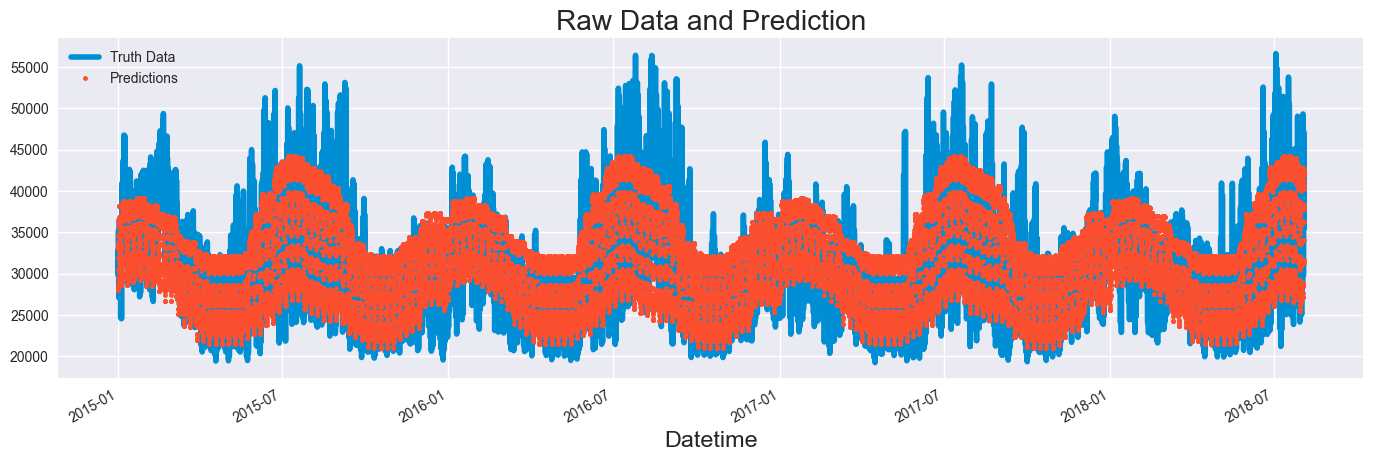

In [257]:
ax = df.query("index >= '01-01-2015'").PJME_MW.plot(figsize=(15, 5))
df.predict.plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction');
# Alot of enhancement can be done

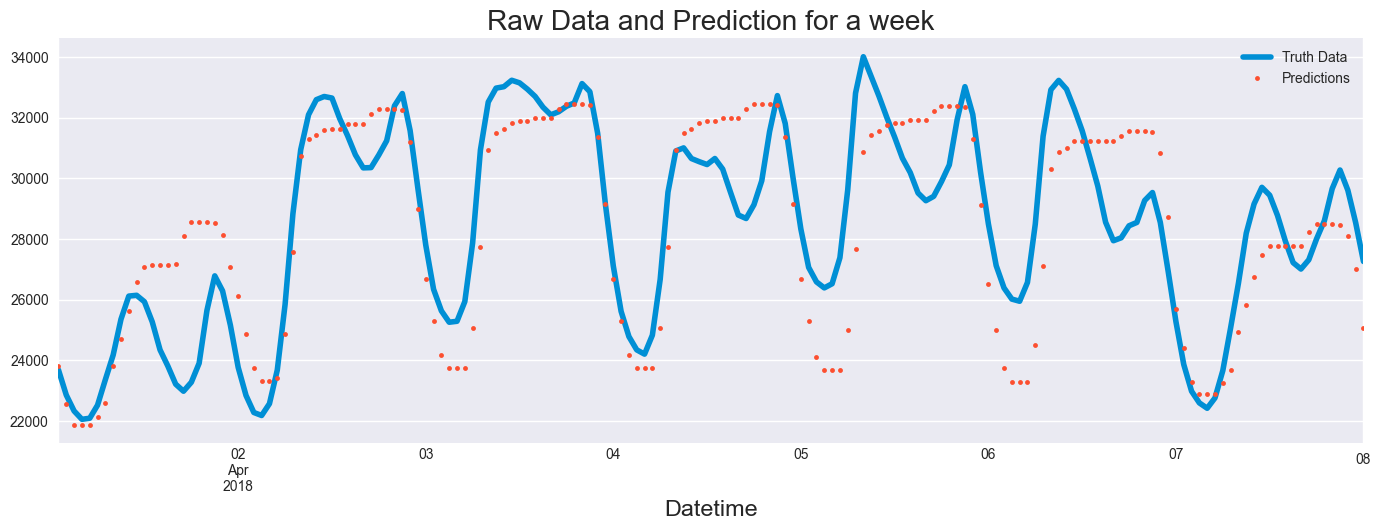

In [259]:
ax = df.query("(index > '04-01-2018')&(index <= '04-08-2018')").PJME_MW.plot(figsize=(15, 5))
df.query("(index > '04-01-2018')&(index <= '04-08-2018')").predict.plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction for a week');

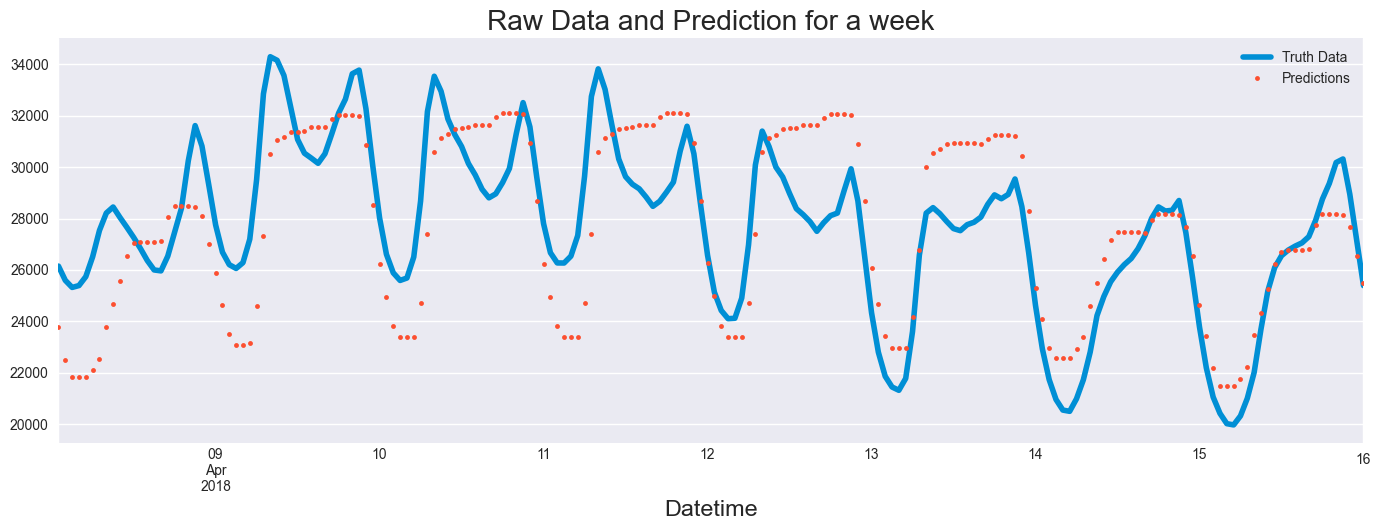

In [261]:
ax = df.query("(index > '04-08-2018')&(index <= '04-16-2018')").PJME_MW.plot(figsize=(15, 5))
df.query("(index > '04-08-2018')&(index <= '04-16-2018')").predict.plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction for a week');

### Evaluate error

In [262]:
rsme_score = np.sqrt(mean_squared_error(test_df.PJME_MW,test_df.predict))
print(f'RMSE Score on Test set is: {rsme_score:0.2f}')

RMSE Score on Test set is: 3721.99


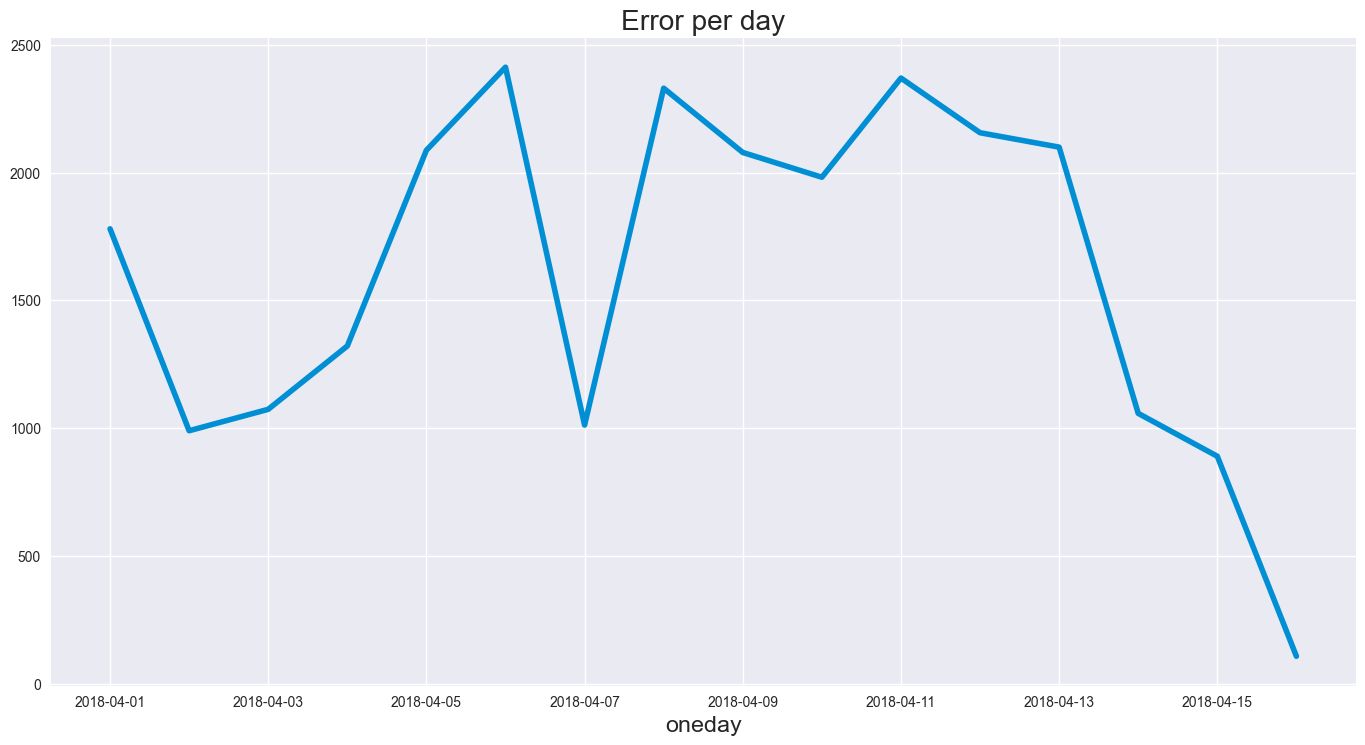

In [278]:
test_df["error"] = np.abs(test_df.PJME_MW - test_df.predict)
test_df["oneday"] = test_df.index.date
test_df.query("(index > '04-01-2018')&(index <= '04-16-2018')").groupby(["oneday"]).error.mean().plot(figsize=(15,8),title="Error per day");

## Potential enhancement
- use cross validation
- Add more features (weather forecast, holidays)